In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('data/official/train.csv', index_col=0)
x_test = pd.read_csv('data/official/test.csv', index_col=0)

In [3]:
len(train), len(x_test)

(19984, 19702)

In [4]:
train.loc[train.problems.isna(),:].describe()

,tree_dbh,health,borocode,boro_ct,cb_num,st_senate,st_assem,cncldist
count,12243.000000,12243.000000,12243.000000,1.224300e+04,12243.000000,12243.000000,12243.000000,12243.000000
mean,9.550927,0.870130,3.383566,3.428115e+06,345.414359,21.186719,52.140243,30.807645
std,7.111644,0.428092,1.234238,1.240936e+06,122.408877,7.110358,18.366462,14.865975
min,1.000000,0.000000,1.000000,1.000202e+06,101.000000,10.000000,23.000000,1.000000
25%,4.000000,1.000000,3.000000,3.006500e+06,302.000000,15.000000,33.000000,19.000000
50%,7.000000,1.000000,4.000000,4.012301e+06,402.000000,23.000000,56.000000,31.000000
75%,14.000000,1.000000,4.000000,4.129104e+06,413.000000,25.000000,64.000000,46.000000
max,41.000000,2.000000,5.000000,5.031902e+06,503.000000,36.000000,87.000000,51.000000


In [5]:
train.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,...,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,...,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,...,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,...,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,...,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9


In [6]:
train.loc[:,"health"].value_counts()
# len(train)

1    15751
0     3535
2      698
Name: health, dtype: int64

In [7]:
for col in train.columns:
    print(train.loc[:,col].value_counts())

2015-10-15    421
2015-10-16    320
2015-10-21    249
2015-09-26    248
2015-11-13    246
             ... 
2016-04-25      4
2016-09-25      3
2016-01-01      3
2016-04-21      2
2016-03-07      2
Name: created_at, Length: 447, dtype: int64
5     1937
4     1912
6     1865
3     1572
7     1341
16     777
8      745
15     741
17     726
14     680
13     596
18     552
9      547
12     513
2      503
11     500
10     490
19     404
26     337
20     335
24     297
25     294
28     290
22     289
27     272
23     271
21     251
29     233
30     191
31     145
32     112
33      69
34      58
1       37
35      35
36      19
37      16
38      12
39       9
40       7
41       3
42       1
Name: tree_dbh, dtype: int64
OnCurb            18777
OffsetFromCurb     1207
Name: curb_loc, dtype: int64
1    15751
0     3535
2      698
Name: health, dtype: int64
1or2       3999
3or4       1079
4orMore      23
Name: steward, dtype: int64
Helpful    3650
Unsure      737
Harmful     654
Name: 

In [8]:
from sklearn.model_selection import train_test_split
from lib.preprocess import Preprocess
train, valid = train_test_split(train, test_size=0.2, random_state=42, stratify=train["health"])

x_train = train.drop("health", axis=1)
y_train = train["health"]
x_valid = valid.drop("health", axis=1)
y_valid = valid["health"]

ignore_columns = [
    "nta_name",
    "boro_ct",
    "spc_latin",
]
# get object columns
object_columns = [col for col in x_train.select_dtypes(include=["object"]).columns.tolist() if col not in ignore_columns]
config = {
    "object_columns": object_columns,
    "is_target_encode": False,
}

preprocess = Preprocess(config)
x_train = pd.DataFrame(preprocess.fit_transform(x_train, y_train), columns=preprocess.get_feature_names_out(), index=x_train.index)
x_valid = pd.DataFrame(preprocess.transform(x_valid), columns=preprocess.get_feature_names_out(), index=x_valid.index)

In [9]:
x_train.cat__steward.fillna(-10, inplace=True)
x_valid.cat__steward.fillna(-10, inplace=True)
x_train.cat__guards.fillna(-10, inplace=True)
x_valid.cat__guards.fillna(-10, inplace=True)

In [10]:
health_drop_df = pd.concat([
    y_train.value_counts(),
    y_train.loc[x_train.cat__steward==-10].value_counts(),
    y_train.loc[x_train.cat__guards==-10].value_counts(),
    y_train.loc[(x_train.cat__steward==-10)&(x_train.cat__guards==-10)].value_counts(),
], axis=1)
health_drop_df.columns = ["all", "steward", "guards", "both"]
# health_drop_df = health_drop_df / health_drop_df.loc[:, "all"].values.reshape(-1, 1)# normalize by all
health_drop_df

,all,steward,guards,both
1,12601,9391,9576,8309
0,2828,2059,1964,1726
2,558,446,408,367


In [11]:
x_train.loc[x_train.cat__steward==-10,"cat__user_type"].value_counts(normalize=True)

2.0    0.497226
1.0    0.340871
0.0    0.161903
Name: cat__user_type, dtype: float64

In [12]:
x_train.loc[:,"cat__user_type"].value_counts(normalize=True)

2.0    0.559705
1.0    0.290611
0.0    0.149684
Name: cat__user_type, dtype: float64

In [13]:
x_train.loc[x_train.cat__guards==-10,"cat__user_type"].value_counts(normalize=True)

2.0    0.494560
1.0    0.341145
0.0    0.164295
Name: cat__user_type, dtype: float64

In [14]:
x_test.isna().sum()

created_at        0
tree_dbh          0
curb_loc          0
steward       14526
guards        14567
sidewalk          0
user_type         0
problems      12045
spc_common        0
spc_latin         0
nta               0
nta_name          0
borocode          0
boro_ct           0
boroname          0
zip_city          0
cb_num            0
st_senate         0
st_assem          0
cncldist          0
dtype: int64

Text(0.5, 1.0, 'tree_dbh all')

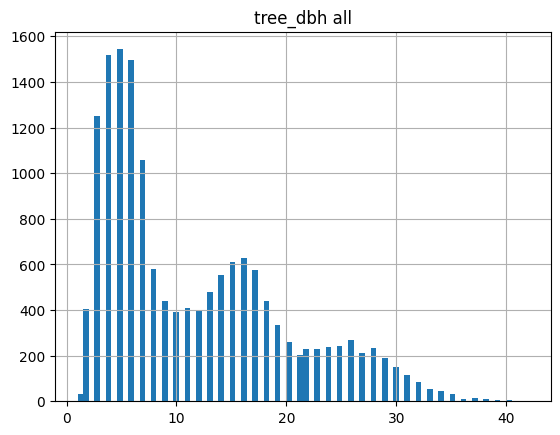

In [15]:
import numpy as np
import matplotlib.pyplot as plt
train["tree_dbh"].hist(bins=80)
plt.title(f"tree_dbh all")

Text(0.5, 1.0, 'tree_dbh all in test data')

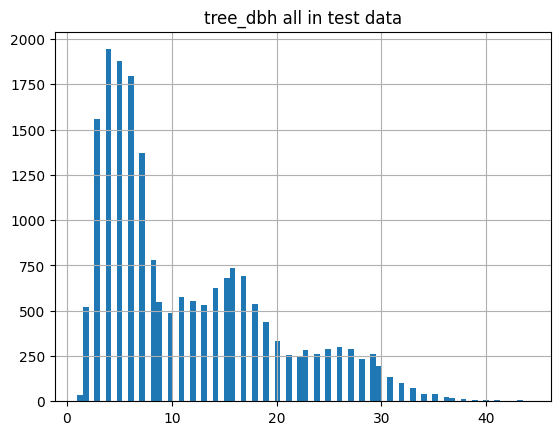

In [16]:
x_test["tree_dbh"].hist(bins=80)
plt.title(f"tree_dbh all in test data")

(0.0, 1700.0)

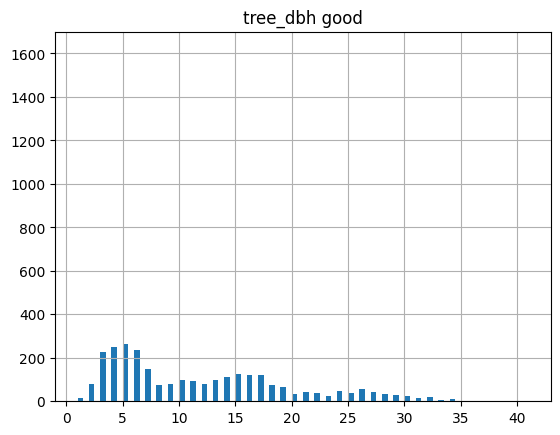

In [17]:
train.loc[train.health==0,"tree_dbh"].hist(bins=80)
plt.title(f"tree_dbh good")
plt.ylim(0,1700)

(0.0, 1700.0)

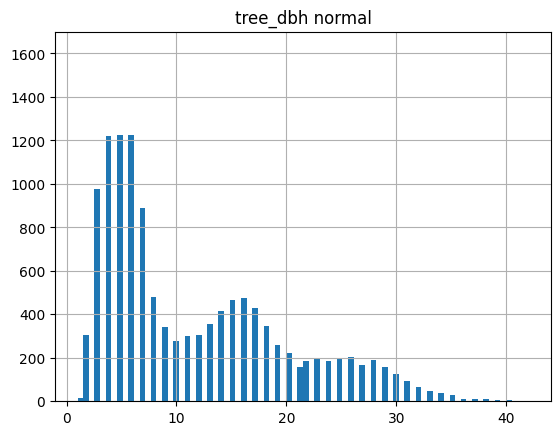

In [18]:
train.loc[train.health==1,"tree_dbh"].hist(bins=80)
plt.title(f"tree_dbh normal")
plt.ylim(0,1700)

(0.0, 1700.0)

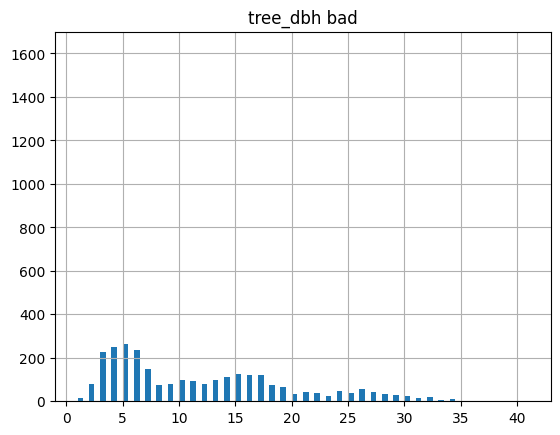

In [19]:
train.loc[train.health==0,"tree_dbh"].hist(bins=80)
plt.title(f"tree_dbh bad")
plt.ylim(0,1700)

In [20]:
train.spc_common.unique()

array(['American elm', 'pin oak', 'red maple', 'Callery pear',
       'London planetree', 'Siberian elm', 'empress tree', 'cherry',
       'Chinese elm', 'green ash', 'Norway maple', 'Sophora', 'pine',
       'honeylocust', 'American linden', 'hedge maple',
       'littleleaf linden', 'Japanese zelkova', 'swamp white oak',
       'silver maple', 'English oak', 'ginkgo', 'black walnut',
       "'Schubert' chokecherry", 'crimson king maple', 'sawtooth oak',
       'hawthorn', 'northern red oak', 'golden raintree', 'sweetgum',
       'cucumber magnolia', 'American hophornbeam', 'maple',
       'black locust', 'eastern redcedar', 'silver birch', 'scarlet oak',
       'shingle oak', 'European hornbeam', 'Japanese tree lilac',
       'silver linden', 'Persian ironwood', 'quaking aspen',
       'dawn redwood', 'sugar maple', 'Amur maackia', 'crab apple',
       'purple-leaf plum', 'arborvitae', 'willow oak', 'eastern redbud',
       'Amur maple', 'eastern cottonwood', 'river birch', 'magnolia

In [21]:
train.columns

Index(['created_at', 'tree_dbh', 'curb_loc', 'health', 'steward', 'guards',
       'sidewalk', 'user_type', 'problems', 'spc_common', 'spc_latin', 'nta',
       'nta_name', 'borocode', 'boro_ct', 'boroname', 'zip_city', 'cb_num',
       'st_senate', 'st_assem', 'cncldist'],
      dtype='object')

In [22]:
score = 0
column = "spc_latin"
unique = train.loc[:,column].unique()[0]
for value, count in train.loc[train.loc[:,column]==unique,"health"].value_counts().items():
    break
    value+=1 # don't want to ignore health=0
    score += value*count
column,unique,score

('spc_latin', 'Ulmus americana', 0)

In [23]:
# from sklearn.preprocessing import TargetEncoder
# te = TargetEncoder(target_type='continuous')
# te.fit_transform(train.loc[:,column],train.loc[:,"health"])
# te = TargetEncoder(target_type='continuous')
# te.fit_transform(train.loc[:,column],train.loc[:,"health"])

In [24]:
column = "nta"
for unique in train.loc[:,column].unique():
    break
    train.loc[train.loc[:,column]==unique,"tree_dbh"].hist(bins=80)
    plt.title(f"tree_dbh {unique}")
    # plt.ylim(0,1700)
    plt.savefig(f"figs/dbh_by_nta/tree_dbh_{unique}.png")
    plt.close()

<AxesSubplot: >

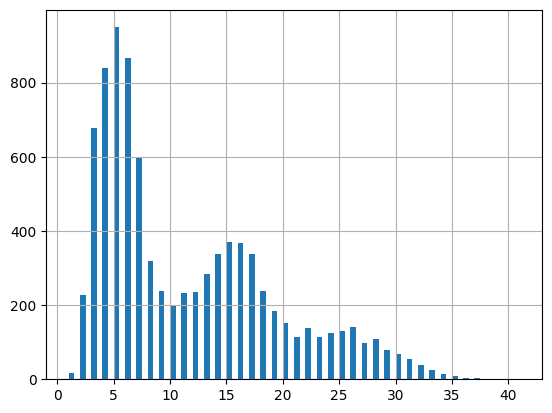

In [25]:
train.loc[train.user_type=='Volunteer', 'tree_dbh'].hist(bins=80)

<AxesSubplot: >

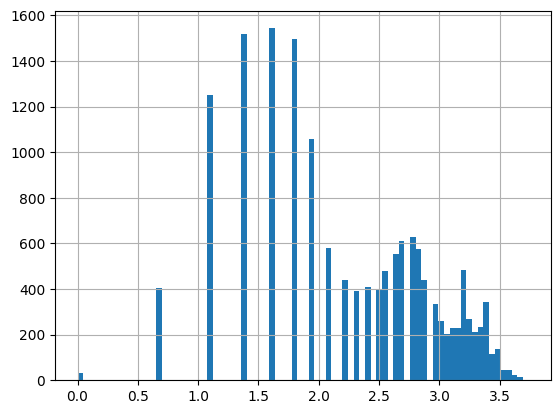

In [26]:
import numpy as np
train["tree_dbh"].apply(lambda x: np.log(x)).hist(bins=80)

/tmp/ipykernel_16463/4007104244.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:,"created_at"] = pd.to_datetime(train.loc[:,"created_at"], format="%m-%d")


Text(0, 0.5, 'health')

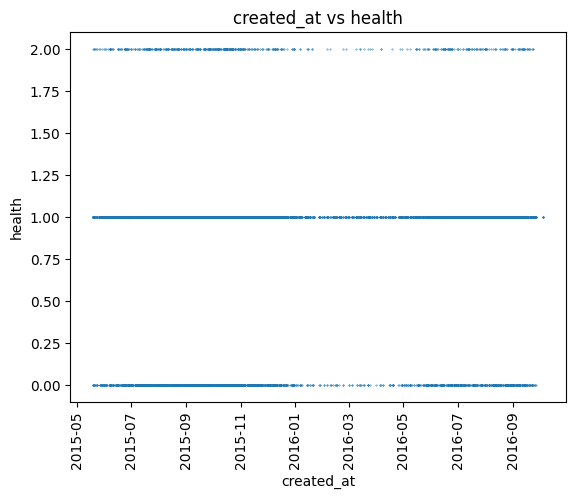

In [38]:
# train.sort_values("created_at").plot(x="created_at", y="health", kind="scatter", s=0.1)
# date format
train.loc[:,"created_at"] = pd.to_datetime(train.loc[:,"created_at"], format="%m-%d")
train.sort_values("created_at").plot(x="created_at", y="health", kind="scatter", s=0.1)
plt.xticks(rotation=90)
plt.title("created_at vs health")
plt.xlabel("created_at")
plt.ylabel("health")